<a href="https://colab.research.google.com/github/konan108/ERC-Rebalancing/blob/main/ERC_HPR_Rebalancing_3jahre_w%C3%B6chentlich_V3_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ============================================================================
# Zelle 1: INSTALLATION & IMPORTS
# ============================================================================

# Installation
%pip install -q gspread gspread-formatting pandas numpy scipy matplotlib scikit-learn

# Core
import numpy as np
import pandas as pd
from datetime import datetime
from zoneinfo import ZoneInfo

# Optimization & Clustering
from scipy.optimize import minimize
from scipy.cluster import hierarchy as sch
from scipy.spatial.distance import squareform

# Shrinkage (NEU)
from sklearn.covariance import LedoitWolf

# Visualization
import matplotlib.pyplot as plt

# Google Sheets
from google.colab import auth
from google.auth import default
import gspread
from gspread_formatting import format_cell_range, CellFormat, NumberFormat

print("✅ Pakete geladen | HRP & ERC & Constraints bereit")

✅ Pakete geladen | HRP & ERC & Constraints bereit


In [ ]:
# ============================================================================
# Zelle 2: CONFIGURATION
# ============================================================================

# Google Sheets
SPREADSHEET_NAME = "ERC_HRP Rebalancing"
SPREADSHEET_ID = "1GpSW_OM6gCy8Ac7g-s8SV1AcnvRycpPVs8qCFlqwMDA"
PRICES_SHEET_NAME = "Prices"
OUTPUT_SHEET_NAME = "Weights"

# Portfolio Parameter
WINDOW_WEEKS_HRP = 156      # 3 Jahre für aktuelle HRP (neueste Struktur)
WINDOW_WEEKS_CONSTRAINTS = 260  # 5 Jahre für robuste Constraints
SATELLITE_SHARE = 0.25      # Satellite-Anteil am Gesamtportfolio (25%)

# Methoden
CALCULATE_ERC = True        # ERC berechnen
CALCULATE_HRP_PURE = True   # HRP Pure (ohne Constraints)
CALCULATE_HRP_CONSTRAINED = True  # HRP mit Constraints (primär)

# Constraints (NEU)
MAX_RISK_CONTRIBUTION = 0.25  # Max 25% Risiko pro Asset
N_BOOTSTRAP = 5000            # Bootstrap-Iterationen (2000→5000 robuster)
USE_SHRINKAGE = True          # Ledoit-Wolf Shrinkage für Kovarianz

# ERC Optimierung
ERC_TOLERANCE = 1e-12
ERC_MAX_ITER = 1000

# Visualisierung
PLOT_DENDROGRAM = True
PLOT_COMPARISON = True
PLOT_RC = True              # Risk Contribution Plots
EXPORT_CSV = False

print("✅ Configuration geladen")
print(f"  • HRP-Window: {WINDOW_WEEKS_HRP} Wochen (~{WINDOW_WEEKS_HRP/52:.1f} Jahre)")
print(f"  • Constraints-Window: {WINDOW_WEEKS_CONSTRAINTS} Wochen (~{WINDOW_WEEKS_CONSTRAINTS/52:.1f} Jahre)")
print(f"  • Bootstrap: {N_BOOTSTRAP} Iterationen")
print(f"  • Shrinkage: {'Ja' if USE_SHRINKAGE else 'Nein'}")
print(f"  • Satellite: {SATELLITE_SHARE*100:.0f}%")

✅ Configuration geladen
  • HRP-Window: 156 Wochen (~3.0 Jahre)
  • Constraints-Window: 260 Wochen (~5.0 Jahre)
  • Bootstrap: 5000 Iterationen
  • Shrinkage: Ja
  • Satellite: 25%


In [ ]:
# ============================================================================
# Zelle 3: GOOGLE SHEETS AUTHENTICATION
# ============================================================================

# Authentifizierung
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

# Spreadsheet öffnen (via ID oder Name)
if SPREADSHEET_ID:
    ss = gc.open_by_key(SPREADSHEET_ID)
    print(f"✅ Google Sheets verbunden (via ID)")
else:
    ss = gc.open(SPREADSHEET_NAME)
    print(f"✅ Google Sheets verbunden: '{SPREADSHEET_NAME}'")

# Worksheets laden
prices_ws = ss.worksheet(PRICES_SHEET_NAME)

try:
    weights_ws = ss.worksheet(OUTPUT_SHEET_NAME)
except gspread.exceptions.WorksheetNotFound:
    weights_ws = ss.add_worksheet(title=OUTPUT_SHEET_NAME, rows=100, cols=10)
    print(f"ℹ️  Output-Sheet '{OUTPUT_SHEET_NAME}' erstellt")

✅ Google Sheets verbunden (via ID)


In [ ]:
# ============================================================================
# Zelle 4: DATA LOADING & PREPROCESSING
# ============================================================================

def load_prices(ws):
    """Lädt Preisdaten aus Google Sheets."""
    raw = ws.get_all_values()

    if len(raw) < 3:
        raise ValueError("Prices-Sheet enthält zu wenig Daten")

    df = pd.DataFrame(raw[1:], columns=raw[0])
    ticker_cols = [col for col in df.columns
                   if col not in ['Date', ''] and col.strip()]
    df = df[['Date'] + ticker_cols].copy()

    df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y', errors='coerce')
    df = df.dropna(subset=['Date'])

    for col in ticker_cols:
        df[col] = (df[col].astype(str)
                   .str.replace(',', '.')
                   .str.replace('"', ''))
        df[col] = pd.to_numeric(df[col], errors='coerce')

    df = df.sort_values('Date').set_index('Date')

    print(f"\n   📊 Daten-Qualität:")
    missing_pct = df.isnull().sum() / len(df)
    for col in ticker_cols:
        pct = missing_pct[col] * 100
        status = "✓" if pct < 5 else "⚠️" if pct < 20 else "❌"
        print(f"   {status} {col:12} {100-pct:5.1f}% vollständig")

    valid_cols = [col for col in ticker_cols if missing_pct[col] < 0.2]
    if len(valid_cols) < len(ticker_cols):
        dropped = set(ticker_cols) - set(valid_cols)
        print(f"\n   ⚠️  Assets entfernt (>20% Lücken): {', '.join(dropped)}")
        df = df[valid_cols]

    df = df.ffill(limit=2)

    initial_rows = len(df)
    df = df.dropna()
    dropped_rows = initial_rows - len(df)

    if dropped_rows > 0:
        print(f"   ℹ️  {dropped_rows} Wochen mit verbleibenden Lücken entfernt")

    if len(df) == 0:
        raise ValueError("Keine gültigen Preisdaten nach Bereinigung!")

    print(f"\n✅ Preisdaten geladen: {len(df)} Wochen | {len(df.columns)} Assets")
    print(f"   Zeitraum: {df.index[0]:%d.%m.%Y} - {df.index[-1]:%d.%m.%Y}")

    return df


def calculate_returns(df_prices, window_weeks=None, label=""):
    """Berechnet wöchentliche Returns mit optionalem Window."""
    returns = df_prices.pct_change().dropna()

    if window_weeks and len(returns) > window_weeks:
        returns = returns.tail(window_weeks)
        print(f"✅ Returns {label}: {window_weeks} Wochen (~{window_weeks/52:.1f} Jahre)")
    else:
        print(f"✅ Returns {label}: {len(returns)} Wochen (~{len(returns)/52:.1f} Jahre)")
        if window_weeks:
            print(f"   ℹ️  Weniger Daten als gewünscht (wollte {window_weeks}, habe {len(returns)})")

    return returns

def cov_shrink_annualized(returns):
    """
    Ledoit-Wolf Shrinkage-Kovarianz, auf Jahresbasis skaliert (×52).
    """
    lw = LedoitWolf()
    lw.fit(returns)
    cov = lw.covariance_ * 52
    return pd.DataFrame(cov, index=returns.columns, columns=returns.columns)

# --- Daten laden ---
print("=" * 70)
print("📊 DATA LOADING")
print("=" * 70)

df_prices = load_prices(prices_ws)

# Zwei verschiedene Return-Windows
returns_3y = calculate_returns(df_prices, WINDOW_WEEKS_HRP, label="(3Y für HRP)")
returns_5y = calculate_returns(df_prices, WINDOW_WEEKS_CONSTRAINTS, label="(5Y für Constraints)")

# Kovarianzmatrizen mit Shrinkage
cov_3y = cov_shrink_annualized(returns_3y)
cov_5y = cov_shrink_annualized(returns_5y)

print(f"\n✅ Zwei Datensätze bereit:")
print(f"   • 3Y: {len(returns_3y)} Wochen für aktuelle HRP-Struktur")
print(f"   • 5Y: {len(returns_5y)} Wochen für robuste Constraints")

# Variablen
tickers = list(df_prices.columns)
n_assets = len(tickers)
returns = returns_3y  # Alias für ERC/HRP
cov_matrix = cov_3y   # Alias für ERC/HRP

print(f"\n✅ Assets: {', '.join(tickers)}")
print("=" * 70)

📊 DATA LOADING

   📊 Daten-Qualität:
   ✓ ABEC.DEX     100.0% vollständig
   ✓ ASML.AMS     100.0% vollständig
   ✓ IUI1.FRK     100.0% vollständig
   ✓ KEE.FRK      100.0% vollständig
   ✓ RMS.PAR      100.0% vollständig
   ✓ SU.PAR       100.0% vollständig
   ✓ 2IS.FRK      100.0% vollständig

✅ Preisdaten geladen: 1185 Wochen | 7 Assets
   Zeitraum: 14.01.2005 - 10.11.2025
✅ Returns (3Y für HRP): 156 Wochen (~3.0 Jahre)
✅ Returns (5Y für Constraints): 260 Wochen (~5.0 Jahre)

✅ Zwei Datensätze bereit:
   • 3Y: 156 Wochen für aktuelle HRP-Struktur
   • 5Y: 260 Wochen für robuste Constraints

✅ Assets: ABEC.DEX, ASML.AMS, IUI1.FRK, KEE.FRK, RMS.PAR, SU.PAR, 2IS.FRK


In [ ]:
# ============================================================================
# Zelle 5: ERC OPTIMIZATION
# ============================================================================

def portfolio_variance(weights, cov):
    """Portfolio-Varianz: w^T × Σ × w"""
    return weights @ cov @ weights


def risk_contributions(weights, cov):
    """
    Berechnet Risikobeiträge jeder Position.

    Returns:
    --------
    rc_pct : array
        Risikobeiträge in % (summiert zu 100%)
    """
    marginal = cov @ weights
    rc = weights * marginal
    rc_pct = rc / rc.sum()
    return rc_pct


def erc_objective(weights, cov):
    """
    ERC Zielfunktion: Minimiere Abweichung von gleichem Risikobeitrag.

    Ziel: Jedes Asset trägt 1/n zum Gesamtrisiko bei.
    """
    rc_pct = risk_contributions(weights, cov)
    target = 1.0 / len(weights)
    return np.sum((rc_pct - target) ** 2)


def optimize_erc(cov):
    """
    Optimiert Portfolio-Gewichte nach ERC-Prinzip.

    Constraints:
    - Long-only: w >= 0
    - Fully invested: sum(w) = 1

    Returns:
    --------
    weights : array
        ERC-optimale Gewichte
    """
    n = len(cov)

    # Startpunkt: Inverse Volatilität (nahe am ERC-Optimum)
    vols = np.sqrt(np.diag(cov))
    inv_vol = 1 / vols
    w0 = inv_vol / inv_vol.sum()

    # Constraints & Bounds
    constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0}
    bounds = [(0, 1) for _ in range(n)]

    # Optimierung mit strenger Toleranz
    result = minimize(
        fun=erc_objective,
        x0=w0,
        args=(cov.values,),
        method='SLSQP',
        bounds=bounds,
        constraints=constraints,
        options={'ftol': ERC_TOLERANCE, 'maxiter': ERC_MAX_ITER}
    )

    if not result.success:
        raise RuntimeError(f"ERC-Optimierung fehlgeschlagen: {result.message}")

    return result.x


print("✅ ERC-Funktionen geladen")

✅ ERC-Funktionen geladen


In [ ]:
# ============================================================================
# Zelle 6: HRP FUNCTIONS
# ============================================================================

def get_cluster_var(cov, items):
    """Berechnet Varianz eines Clusters."""
    cov_slice = cov.loc[items, items] # FIX: Changed .iloc to .loc
    w = 1 / np.diag(cov_slice)  # Inverse variance
    w /= w.sum()
    return w @ cov_slice @ w


def get_recursive_bisection(cov, sorted_items):
    """
    Recursive Bisection: Allokiert Gewichte entlang der Cluster-Hierarchie.

    Dies ist der Kern von HRP!
    """
    w = pd.Series(1.0, index=sorted_items)
    items = [sorted_items]

    while len(items) > 0:
        items = [i[j:k] for i in items
                 for j, k in ((0, len(i) // 2), (len(i) // 2, len(i)))
                 if len(i) > 1]

        for i in range(0, len(items), 2):
            items0 = items[i]
            items1 = items[i + 1]

            # Cluster-Varianzen
            var0 = get_cluster_var(cov, items0)
            var1 = get_cluster_var(cov, items1)

            # Allokation umgekehrt zur Varianz
            alpha = 1 - var0 / (var0 + var1)

            # Gewichte anpassen
            w[items0] *= alpha
            w[items1] *= 1 - alpha

    return w


def hierarchical_risk_parity(returns, use_shrinkage=False):
    """
    Berechnet HRP-Gewichte.

    use_shrinkage:
        False -> klassische Kovarianz
        True  -> Ledoit-Wolf Shrinkage-Kovarianz
    """
    # Korrelation & Distanz (immer aus normalen Returns)
    corr = returns.corr()
    dist = np.sqrt(0.5 * (1 - corr))

    # Hierarchisches Clustering (Ward, wie gehabt)
    link = sch.linkage(squareform(dist), method='ward')

    # Sortierung aus Dendrogramm
    dendro = sch.dendrogram(link, labels=corr.columns.tolist(), no_plot=True)
    sorted_tickers = dendro['ivl']

    # Kovarianzmatrix (annualisiert)
    if use_shrinkage:
        lw = LedoitWolf()
        lw.fit(returns)
        cov = pd.DataFrame(lw.covariance_ * 52,
                           index=returns.columns,
                           columns=returns.columns)
    else:
        cov = returns.cov() * 52

    cov = cov.loc[sorted_tickers, sorted_tickers]

    # Recursive Bisection
    weights = get_recursive_bisection(cov, sorted_tickers)

    # Zurück in Original-Reihenfolge
    weights = weights[returns.columns]

    return weights.values, link, sorted_tickers


print("✅ HRP-Funktionen geladen (echtes Recursive Bisection)")

✅ HRP-Funktionen geladen (echtes Recursive Bisection)


In [ ]:
# ============================================================================
# Zelle 7: PORTFOLIO OPTIMIZATION: ERC & HRP
# ============================================================================

print("=" * 70)
print("📊 PORTFOLIO OPTIMIZATION")
print("=" * 70)

# --- ERC Berechnung ---
if CALCULATE_ERC:
    print("\n🔵 ERC (Equal Risk Contribution)...")
    weights_erc = optimize_erc(cov_matrix)
    rc_erc = risk_contributions(weights_erc, cov_matrix.values)
    vol_erc = np.sqrt(weights_erc @ cov_matrix.values @ weights_erc)
    print(f"   Portfolio Vol: {vol_erc:.2%}")

# --- HRP Pure Berechnung ---
if CALCULATE_HRP_PURE:
    print("\n🟢 HRP Pure (Hierarchical Risk Parity)...")
    weights_hrp, linkage_hrp, sorted_tickers = hierarchical_risk_parity(returns, use_shrinkage=True)
    rc_hrp = risk_contributions(weights_hrp, cov_matrix.values)
    vol_hrp = np.sqrt(weights_hrp @ cov_matrix.values @ weights_hrp)
    print(f"   Portfolio Vol: {vol_hrp:.2%}")
    print(f"   Cluster-Ordnung: {' → '.join(sorted_tickers)}")

# --- Vergleich ---
if CALCULATE_ERC and CALCULATE_HRP_PURE:
    delta_w = np.abs(weights_erc - weights_hrp).sum()
    print(f"\n📊 Vergleich:")
    print(f"   Gewichts-Differenz: {delta_w:.2%}")

print("\n" + "=" * 70)
print("✅ OPTIMIZATION COMPLETED")
print("=" * 70)

📊 PORTFOLIO OPTIMIZATION

🔵 ERC (Equal Risk Contribution)...
   Portfolio Vol: 18.68%

🟢 HRP Pure (Hierarchical Risk Parity)...
   Portfolio Vol: 18.49%
   Cluster-Ordnung: IUI1.FRK → 2IS.FRK → ABEC.DEX → KEE.FRK → ASML.AMS → RMS.PAR → SU.PAR

📊 Vergleich:
   Gewichts-Differenz: 14.57%

✅ OPTIMIZATION COMPLETED


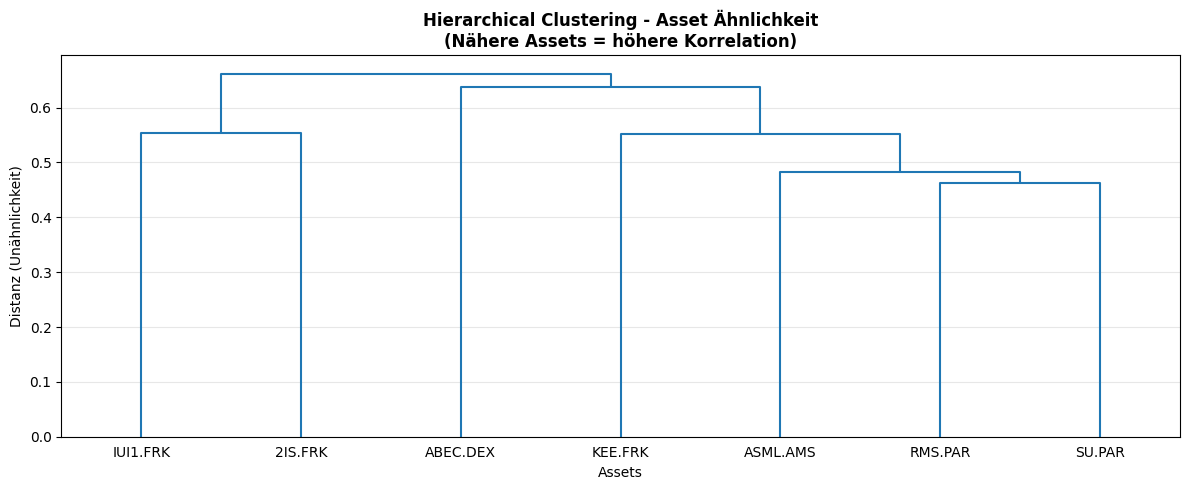

✅ Dendrogramm erstellt


In [ ]:
# ============================================================================
# Zelle 8: DENDROGRAMM VISUALISIERUNG
# ============================================================================

if CALCULATE_HRP_PURE and PLOT_DENDROGRAM:
    fig, ax = plt.subplots(figsize=(12, 5))

    sch.dendrogram(
        linkage_hrp,
        labels=tickers,
        ax=ax,
        leaf_font_size=10,
        color_threshold=0
    )

    ax.set_title('Hierarchical Clustering - Asset Ähnlichkeit\n(Nähere Assets = höhere Korrelation)',
                 fontsize=12, weight='bold')
    ax.set_ylabel('Distanz (Unähnlichkeit)')
    ax.set_xlabel('Assets')
    ax.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("✅ Dendrogramm erstellt")

In [ ]:
# ============================================================================
# Zelle 09: CONSTRAINED HRP
# ============================================================================

def derive_smart_constraints(returns, cov_matrix,
                              max_risk_contribution=0.22,
                              n_bootstrap=2000,
                              use_shrinkage=True,
                              block_size=4):
    """
    Leitet Constraints ab durch Risk-Budget + HRP-Bootstrap.

    returns: DataFrame (5Y-Renditen)
    cov_matrix: DataFrame (5Y-Kovarianz, annualisiert, idealerweise mit Shrinkage)
    """
    n_assets = len(cov_matrix)
    tickers = returns.columns

    print("\n" + "=" * 70)
    print("📊 CONSTRAINT DERIVATION")
    print("=" * 70)

    # ========================================================================
    # Methode A: Risk-Budget (Max Risk Contribution)
    # ========================================================================
    print(f"\n🔵 Risk-Budget: Max {max_risk_contribution*100:.0f}% pro Asset\n")

    equal_weights = np.ones(n_assets) / n_assets
    portfolio_vol = np.sqrt(equal_weights @ cov_matrix.values @ equal_weights)

    rc_max_weights = {}
    for i, ticker in enumerate(tickers):
        asset_vol = np.sqrt(cov_matrix.iloc[i, i])
        max_weight = (max_risk_contribution * portfolio_vol) / asset_vol
        rc_max_weights[ticker] = min(max_weight, 0.35)
        print(f"   {ticker:8s}  Vol: {asset_vol*100:5.1f}%  →  Max: {rc_max_weights[ticker]*100:5.1f}%")

    # ========================================================================
    # Methode B: Block-Bootstrap + HRP-Gewichte
    # ========================================================================
    print(f"\n🟢 Bootstrap (Block-Bootstrap, HRP): {n_bootstrap} Iterationen")
    print("   " + "." * 50)

    weights_distribution = []
    failed = 0
    T = len(returns)
    block_size = max(1, int(block_size))

    for b in range(n_bootstrap):
        if b % 400 == 0:
            print(f"   Progress: {b}/{n_bootstrap} (✓{len(weights_distribution)} ✗{failed})", end='\r')

        try:
            # Block-Bootstrap Indizes erzeugen
            idx = []
            while len(idx) < T:
                start = np.random.randint(0, max(T - block_size + 1, 1))
                block = list(range(start, min(start + block_size, T)))
                idx.extend(block)
            idx = np.array(idx[:T])

            sample_returns = returns.iloc[idx]

            # HRP auf Sample-Renditen
            weights_boot, _, _ = hierarchical_risk_parity(sample_returns, use_shrinkage=True)
            if np.any(np.isnan(weights_boot)) or np.any(weights_boot < 0):
                failed += 1
                continue

            weights_distribution.append(weights_boot)

        except Exception as e:
            failed += 1
            continue

    print(f"\n   ✅ {len(weights_distribution)} Erfolge ({failed} Fehler)\n")

    if len(weights_distribution) < 100:
        print("   ⚠️  Fallback: Nur Risk-Budget-basierte Default-Bounds")
        bs_min = {ticker: 0.05 for ticker in tickers}
        bs_max = {ticker: 0.40 for ticker in tickers}
    else:
        weights_dist = np.array(weights_distribution)
        mean_w = weights_dist.mean(axis=0)
        std_w = weights_dist.std(axis=0)

        print("   Ticker      Mean    Std     Min(μ-3σ)  Max(μ+3σ)")
        print("   " + "-" * 60)

        bs_min = {}
        bs_max = {}
        for i, ticker in enumerate(tickers):
            lo = mean_w[i] - 2 * std_w[i]
            hi = mean_w[i] + 2 * std_w[i]
            bs_min[ticker] = max(lo, 0.05)
            bs_max[ticker] = min(hi, 0.40)
            print(f"   {ticker:8s}  {mean_w[i]*100:5.1f}%  {std_w[i]*100:4.1f}%   "
                  f"{bs_min[ticker]*100:5.1f}%      {bs_max[ticker]*100:5.1f}%")

    # ========================================================================
    # Finale Constraints (Bootstrap ∩ Risk-Budget, mit Floor 8 %)
    # ========================================================================
    print("\n🎯 Finale Constraints (inkl. 8%-Floor & RC-Cap)")
    print("   " + "-" * 55)

    final_min = np.zeros(n_assets)
    final_max = np.zeros(n_assets)

    for i, ticker in enumerate(tickers):
        final_min[i] = max(bs_min[ticker], 0.08)
        final_max[i] = min(bs_max[ticker], rc_max_weights[ticker])
        print(f"   {ticker:8s}  Min: {final_min[i]*100:5.1f}%   Max: {final_max[i]*100:5.1f}%")

    # ========================================================================
    # Feasibility-Check: Summe der Min-/Max-Constraints
    # ========================================================================
    sum_min = final_min.sum()
    sum_max = final_max.sum()

    if sum_min > 1.0 + 1e-8:
        print(f"\n⚠️  Summe der Min-Constraints = {sum_min:.3f} > 1.0 → Reskalierung der Minima.")
        final_min = final_min / sum_min  # proportional zurückskalieren
        sum_min = final_min.sum()

    if sum_max < 1.0 - 1e-8:
        print(f"\n⚠️  Summe der Max-Constraints = {sum_max:.3f} < 1.0 → Reskalierung der Maxima.")
        # Maxima proportional hochskalieren
        final_max = final_max / sum_max
        sum_max = final_max.sum()

    print(f"\n   Sum(min) = {sum_min:.3f}, Sum(max) = {sum_max:.3f}")
    print("=" * 70 + "\n")

    return final_min, final_max


def hrp_with_constraints(returns, min_constraints, max_constraints, max_iter=100):
    """
    HRP mit Projektion auf den Simplex mit Box-Constraints.

    Ziel:
      min ||w - w_HRP||^2
    s.t. sum(w) = 1,  min_constraints[i] <= w[i] <= max_constraints[i]
    """
    base_weights, linkage, sorted_tickers = hierarchical_risk_parity(returns, use_shrinkage=True)
    base_weights = np.asarray(base_weights, dtype=float)
    n = len(base_weights)

    lb = np.asarray(min_constraints, dtype=float)
    ub = np.asarray(max_constraints, dtype=float)

    # Initialer Startwert: HRP-Gewichte geclippt und renormalisiert
    w0 = np.clip(base_weights, lb, ub)
    s0 = w0.sum()
    if s0 <= 0:
        w0 = (lb + ub) / 2.0
        s0 = w0.sum()
    w0 = w0 / s0

    def objective(w):
        return 0.5 * np.sum((w - base_weights) ** 2)

    cons = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0}
    bounds = list(zip(lb, ub))

    res = minimize(
        objective,
        w0,
        method='SLSQP',
        bounds=bounds,
        constraints=cons,
        options={'ftol': 1e-12, 'maxiter': 200}
    )

    if not res.success:
        print(f"⚠️ Projektion nicht konvergent: {res.message}. Fallback auf Clipping+Normierung.")
        w_clip = np.clip(base_weights, lb, ub)
        s = w_clip.sum()
        if s > 0:
            return w_clip / s
        else:
            return np.full(n, 1.0 / n)

    return res.x


# ============================================================================
# BERECHNUNG
# ============================================================================

if CALCULATE_HRP_CONSTRAINED:
    print("\n" + "=" * 70)
    print("🔵 HRP CONSTRAINED")
    print("=" * 70)

    # Constraints ableiten (mit 5Y Daten)
    min_constr, max_constr = derive_smart_constraints(
        returns_5y, cov_5y,
        max_risk_contribution=MAX_RISK_CONTRIBUTION,
        n_bootstrap=N_BOOTSTRAP,
        use_shrinkage=USE_SHRINKAGE
    )

    # HRP mit Constraints (mit 3Y Daten)
    print("\n🔄 Berechne HRP mit Constraints (3Y Daten)...\n")
    weights_hrp_constr = hrp_with_constraints(returns_3y, min_constr, max_constr)
    rc_hrp_constr = risk_contributions(weights_hrp_constr, cov_matrix.values)
    vol_hrp_constr = np.sqrt(weights_hrp_constr @ cov_matrix.values @ weights_hrp_constr)

    print(f"✅ HRP Constrained berechnet")
    print(f"   Portfolio Vol: {vol_hrp_constr:.2%}\n")

    # Vergleich HRP Pure vs. Constrained
    print("📊 Vergleich: HRP Pure vs. Constrained\n")
    comparison_hrp = pd.DataFrame({
        'Ticker': tickers,
        'HRP Pure': [f"{w:.2%}" for w in weights_hrp],
        'HRP Constr': [f"{w:.2%}" for w in weights_hrp_constr],
        'Δ': [f"{weights_hrp_constr[i]-weights_hrp[i]:+.1%}" for i in range(len(tickers))],
        'RC_Pure': [f"{rc:.1%}" for rc in rc_hrp],
        'RC_Constr': [f"{rc:.1%}" for rc in rc_hrp_constr]
    })

    print(comparison_hrp.to_string(index=False))

    print("\n" + "=" * 70)
    print("✅ HRP CONSTRAINED COMPLETED")
    print("=" * 70)


🔵 HRP CONSTRAINED

📊 CONSTRAINT DERIVATION

🔵 Risk-Budget: Max 25% pro Asset

   ABEC.DEX  Vol:  28.9%  →  Max:  17.6%
   ASML.AMS  Vol:  36.8%  →  Max:  13.8%
   IUI1.FRK  Vol:  31.5%  →  Max:  16.2%
   KEE.FRK   Vol:  29.4%  →  Max:  17.3%
   RMS.PAR   Vol:  29.6%  →  Max:  17.2%
   SU.PAR    Vol:  26.7%  →  Max:  19.0%
   2IS.FRK   Vol:  27.2%  →  Max:  18.7%

🟢 Bootstrap (Block-Bootstrap, HRP): 5000 Iterationen
   ..................................................

   ✅ 5000 Erfolge (0 Fehler)

   Ticker      Mean    Std     Min(μ-3σ)  Max(μ+3σ)
   ------------------------------------------------------------
   ABEC.DEX   16.9%   3.2%    10.6%       23.3%
   ASML.AMS    8.1%   1.6%     5.0%       11.3%
   IUI1.FRK   13.5%   2.8%     7.8%       19.1%
   KEE.FRK    15.3%   2.9%     9.5%       21.1%
   RMS.PAR    12.4%   2.1%     8.2%       16.7%
   SU.PAR     16.0%   2.6%    10.8%       21.3%
   2IS.FRK    17.7%   2.9%    12.0%       23.5%

🎯 Finale Constraints (inkl. 8%-Floor & RC-

In [ ]:
# ============================================================================
# WRITE BOUNDS + TARGETS INS SHEET
# ============================================================================

print("\n📝 Schreibe Bound-Tabelle ins Sheet...")

berlin_tz = ZoneInfo("Europe/Berlin")
timestamp = datetime.now(berlin_tz).strftime("%Y-%m-%d %H:%M:%S CET")

data = [[f"Bound Check - Updated: {timestamp}"]]
data.append([])
data.append(["Ticker", "Floor (Min)", "Target (w_HRP_Constr)", "Cap (Max)"])

for i, ticker in enumerate(tickers):
    data.append([
        ticker,
        float(min_constr[i]),
        float(weights_hrp_constr[i]),
        float(max_constr[i])
    ])

weights_ws.clear()
weights_ws.update(range_name="A1", values=data)

# Nummern als Prozent formatieren
pct_fmt = CellFormat(numberFormat=NumberFormat(type='PERCENT', pattern='0.00%'))
format_cell_range(weights_ws, 'B:D', pct_fmt)

print("✅ Bounds & Targets erfolgreich geschrieben.")



📝 Schreibe Bound-Tabelle ins Sheet...
✅ Bounds & Targets erfolgreich geschrieben.


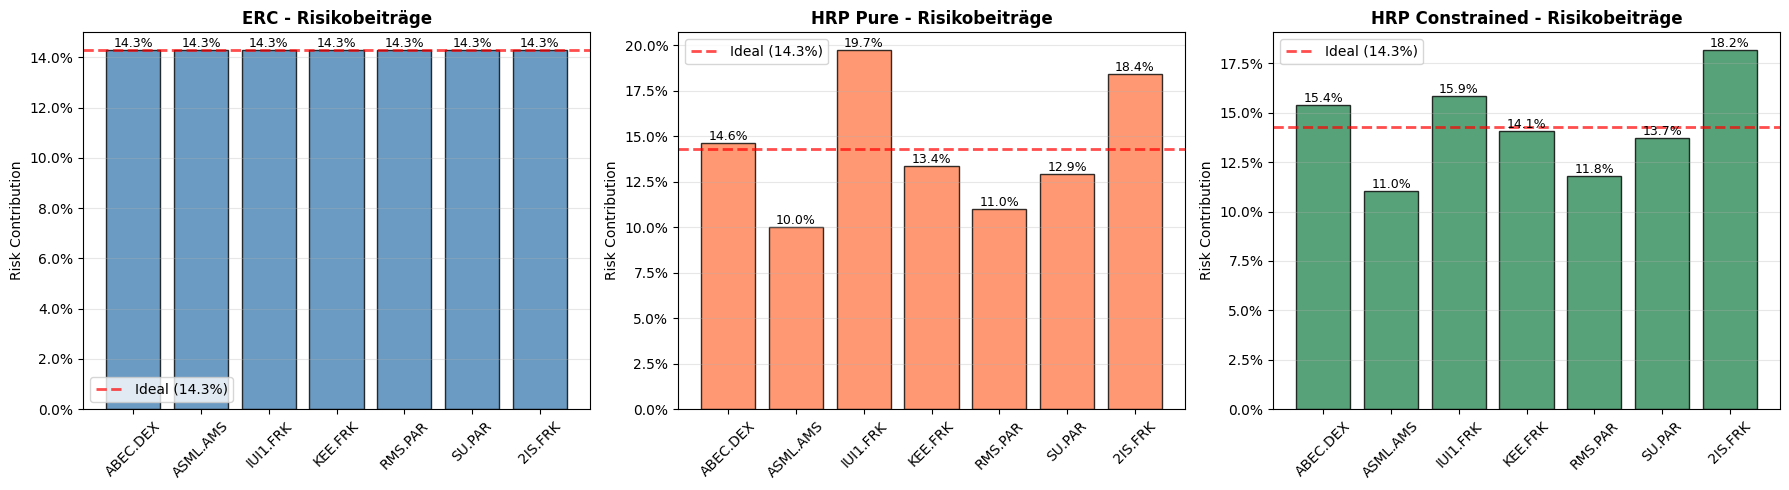

✅ Risk Contribution Plots erstellt (3 Methoden)


In [ ]:
# ============================================================================
# Zelle 12: RISK CONTRIBUTION VISUALIZATION
# ============================================================================

if PLOT_RC:
    # Zähle aktive Methoden
    methods = []
    if CALCULATE_ERC:
        methods.append(('ERC', rc_erc, 'steelblue'))
    if CALCULATE_HRP_PURE:
        methods.append(('HRP Pure', rc_hrp, 'coral'))
    if CALCULATE_HRP_CONSTRAINED:
        methods.append(('HRP Constrained', rc_hrp_constr, 'seagreen'))

    n_plots = len(methods)

    if n_plots > 0:
        fig, axes = plt.subplots(1, n_plots, figsize=(6*n_plots, 5))
        if n_plots == 1:
            axes = [axes]

        ideal_rc = 1.0 / len(tickers)

        for idx, (method_name, rc_values, color) in enumerate(methods):
            ax = axes[idx]

            # Bar chart
            ax.bar(tickers, rc_values, color=color, alpha=0.8, edgecolor='black')

            # Ideal line
            ax.axhline(ideal_rc, color='red', linestyle='--', linewidth=2,
                      label=f'Ideal ({ideal_rc:.1%})', alpha=0.7)

            # Styling
            ax.set_title(f'{method_name} - Risikobeiträge', fontsize=12, weight='bold')
            ax.set_ylabel('Risk Contribution')
            ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.1%}'))
            ax.grid(axis='y', alpha=0.3)
            ax.tick_params(axis='x', rotation=45)
            ax.legend()

            # Value labels
            for i, val in enumerate(rc_values):
                ax.text(i, val, f'{val:.1%}', ha='center', va='bottom', fontsize=9)

        plt.tight_layout()
        plt.show()

        print(f"✅ Risk Contribution Plots erstellt ({n_plots} Methoden)")

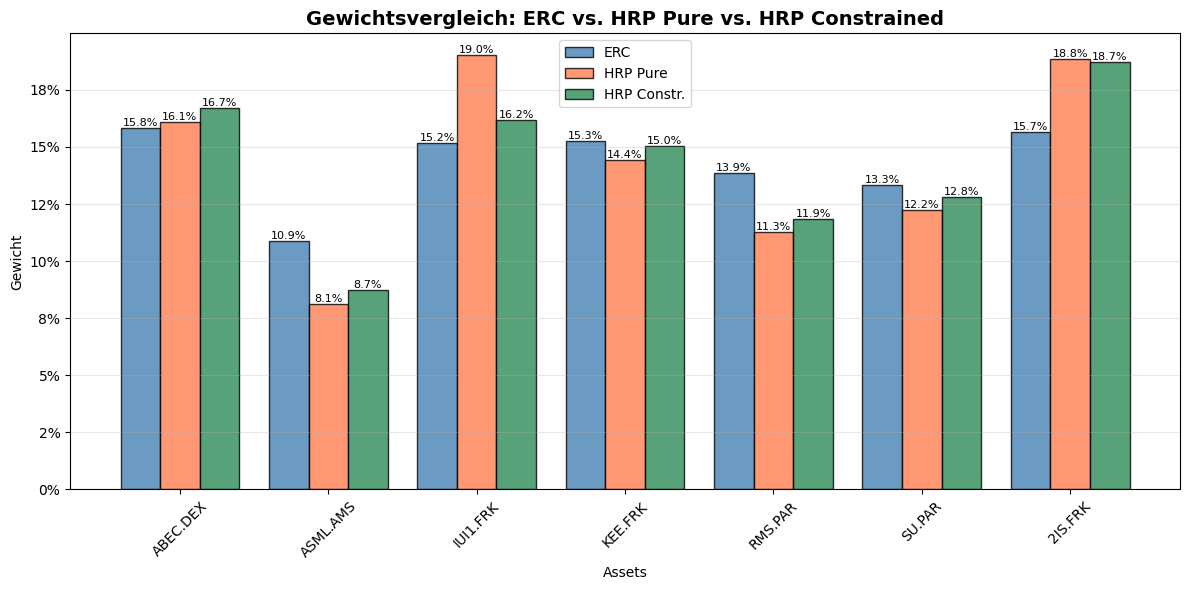

✅ Side-by-Side Vergleich erstellt

📊 GEWICHTS-STATISTIK:

  Ticker    ERC HRP Pure HRP Constr Δ (Constr-ERC)
ABEC.DEX 15.81%   16.09%     16.69%          +0.9%
ASML.AMS 10.86%    8.12%      8.71%          -2.1%
IUI1.FRK 15.19%   19.02%     16.16%          +1.0%
 KEE.FRK 15.26%   14.45%     15.04%          -0.2%
 RMS.PAR 13.87%   11.25%     11.85%          -2.0%
  SU.PAR 13.34%   12.23%     12.83%          -0.5%
 2IS.FRK 15.66%   18.84%     18.72%          +3.1%


In [ ]:
# ============================================================================
# Zelle 13: SIDE-BY-SIDE GEWICHTSVERGLEICH
# ============================================================================

if PLOT_COMPARISON:
    # Sammle alle Methoden
    methods_data = []
    colors = []

    if CALCULATE_ERC:
        methods_data.append(('ERC', weights_erc))
        colors.append('steelblue')
    if CALCULATE_HRP_PURE:
        methods_data.append(('HRP Pure', weights_hrp))
        colors.append('coral')
    if CALCULATE_HRP_CONSTRAINED:
        methods_data.append(('HRP Constr.', weights_hrp_constr))
        colors.append('seagreen')

    n_methods = len(methods_data)

    if n_methods > 1:
        # Grouped bar chart
        fig, ax = plt.subplots(figsize=(12, 6))

        x = np.arange(len(tickers))
        width = 0.8 / n_methods

        for idx, (method_name, weights_data) in enumerate(methods_data):
            offset = (idx - n_methods/2 + 0.5) * width
            bars = ax.bar(x + offset, weights_data, width,
                         label=method_name, color=colors[idx], alpha=0.8, edgecolor='black')

            # Value labels
            for i, bar in enumerate(bars):
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{weights_data[i]:.1%}',
                       ha='center', va='bottom', fontsize=8)

        ax.set_xlabel('Assets')
        ax.set_ylabel('Gewicht')
        ax.set_title('Gewichtsvergleich: ERC vs. HRP Pure vs. HRP Constrained',
                    fontsize=14, weight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(tickers, rotation=45)
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
        ax.legend()
        ax.grid(axis='y', alpha=0.3)

        plt.tight_layout()
        plt.show()

        print(f"✅ Side-by-Side Vergleich erstellt")

        # Statistik-Tabelle
        print("\n📊 GEWICHTS-STATISTIK:\n")

        stats = pd.DataFrame({
            'Ticker': tickers
        })

        if CALCULATE_ERC:
            stats['ERC'] = [f"{w:.2%}" for w in weights_erc]
        if CALCULATE_HRP_PURE:
            stats['HRP Pure'] = [f"{w:.2%}" for w in weights_hrp]
        if CALCULATE_HRP_CONSTRAINED:
            stats['HRP Constr'] = [f"{w:.2%}" for w in weights_hrp_constr]

        # Abweichungen
        if CALCULATE_ERC and CALCULATE_HRP_CONSTRAINED:
            delta = weights_hrp_constr - weights_erc
            stats['Δ (Constr-ERC)'] = [f"{d:+.1%}" for d in delta]

        print(stats.to_string(index=False))

In [ ]:
# ============================================================================
# Zelle 14: CSV EXPORT (OPTIONAL)
# ============================================================================

if EXPORT_CSV:
    dfs = []

    # ERC
    if CALCULATE_ERC:
        df_erc = pd.DataFrame({
            'Ticker': tickers,
            'SleeveWeight': weights_erc,
            'PortfolioWeight': weights_erc * SATELLITE_SHARE,
            'RiskContribution': rc_erc,
            'Method': 'ERC'
        })
        df_erc.to_csv('/content/erc_weights.csv', index=False)
        dfs.append(df_erc)
        print(f"✅ ERC exportiert: /content/erc_weights.csv")

    # HRP Pure
    if CALCULATE_HRP_PURE:
        df_hrp_pure = pd.DataFrame({
            'Ticker': tickers,
            'SleeveWeight': weights_hrp,
            'PortfolioWeight': weights_hrp * SATELLITE_SHARE,
            'RiskContribution': rc_hrp,
            'Method': 'HRP_Pure'
        })
        df_hrp_pure.to_csv('/content/hrp_pure_weights.csv', index=False)
        dfs.append(df_hrp_pure)
        print(f"✅ HRP Pure exportiert: /content/hrp_pure_weights.csv")

    # HRP Constrained
    if CALCULATE_HRP_CONSTRAINED:
        df_hrp_constr = pd.DataFrame({
            'Ticker': tickers,
            'SleeveWeight': weights_hrp_constr,
            'PortfolioWeight': weights_hrp_constr * SATELLITE_SHARE,
            'RiskContribution': rc_hrp_constr,
            'Method': 'HRP_Constrained'
        })
        df_hrp_constr.to_csv('/content/hrp_constrained_weights.csv', index=False)
        dfs.append(df_hrp_constr)
        print(f"✅ HRP Constrained exportiert: /content/hrp_constrained_weights.csv")

    # Kombiniert
    if len(dfs) > 0:
        df_combined = pd.concat(dfs, ignore_index=True)
        df_combined.to_csv('/content/portfolio_comparison_all.csv', index=False)
        print(f"✅ Alle Methoden exportiert: /content/portfolio_comparison_all.csv")

        # Pivot für direkten Vergleich
        df_pivot = df_combined.pivot(index='Ticker', columns='Method', values='SleeveWeight')
        df_pivot.to_csv('/content/portfolio_comparison_pivot.csv')
        print(f"✅ Pivot-Vergleich exportiert: /content/portfolio_comparison_pivot.csv")